In [ ]:
# Import nessesary libraries
import pandas as pd
import glob
import csv
import re
from collections import Counter
import itertools

# NLP libraries
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import bigrams as nltkbigrams
from gensim.utils import simple_preprocess
from gensim.corpora.dictionary import Dictionary
from gensim.corpora import MmCorpus
from gensim.models import LdaModel, LdaMulticore, CoherenceModel
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS

# Visualisation libraries
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import networkx as nx
import pyLDAvis
import pyLDAvis.gensim

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Importing saved articles

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/wiki_nlp/Eastern Europe Wiki'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/15s6PM-2Nd6EW69jV8dfs1SLHd7lUYTnj/wiki_nlp/Eastern Europe Wiki


In [ ]:
# Read the list of Women EE names
df = pd.read_csv('EE_name_country.csv', names = ['name', 'country'])
#Save list of countries
country_list = df.country.unique()

# Import all CSV files from all Wiki articles and save them to one list
articles_df = pd.DataFrame({'articles': [], 'country': []})

for country in country_list:
    filename = country +'_*.csv'
    files = glob.glob('EE_articles/' + filename)

    all_articles = []
    for file in files:
        read_handle = open(file, "r")
        text = list(csv.reader(read_handle, delimiter=","))
        for article in text[1:]:
            all_articles.append(article[1])

    country_df = pd.DataFrame({'articles': all_articles, 'country': country})
    articles_df = pd.concat([articles_df, country_df], ignore_index=True)

# How many articles has been read
print('Number of articles:', len(articles_df))

# Drop duplicates
articles_df = articles_df.drop_duplicates()

# Count the number of rows after
lenAfter = len(articles_df)
print("After de-duplication: " + str(lenAfter))

# Number of articles in initial list by country
articles_df.groupby('country').count()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of articles: 655
After de-duplication: 653


,articles
country,
Belarus,14
Bulgaria,21
CZ,15
Hungary,55
Moldova,59
Poland,141
RU,169
Romania,51
Ukraine,128


## Preprocessing and tokenisation

In [ ]:
# Based on https://www.geeksforgeeks.org/nlp-gensim-tutorial-complete-guide-for-beginners/

all_tokens = []

# import stopwords
stop_words = stopwords.words('english')

wnl = WordNetLemmatizer()

# Check for latin alphabet
# https://stackoverflow.com/questions/27084617/detect-strings-with-non-english-characters-in-python
def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True


for article in articles_df['articles']:
    # Removing section headers and new line breaks
    text = re.sub("==.*==",'', article)
    text = re.sub("\n",'', text)

    # Convert a document into a list of tokens
    # This lowercases, tokenizes, removes numerical values
    tokens = simple_preprocess(text)

    doc_out = []
    for word in tokens:
        if word not in stop_words:  # to remove stopwords
            if isEnglish(word):
                Lemmatized_Word = wnl.lemmatize(word)  # lemmatize
                doc_out.append(Lemmatized_Word)

    all_tokens.append(doc_out)

# Print out infromation about articles and number of tokens for top 15
print('Tokens groups:', len(all_tokens),'\n')
print("{0:7}{1:10}".format("-No-","--Tokens--"))
for x, tokens in enumerate(all_tokens[:15]):
    print("{0:3}{1:10}".format(x + 1, len(tokens)))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Tokens groups: 653 

-No-   --Tokens--
  1      1468
  2       976
  3       140
  4       320
  5      1289
  6       343
  7        31
  8       579
  9       268
 10       197
 11       138
 12       273
 13       280
 14       248
 15       341


## Dictionary and corpus

In [ ]:
# create dictionary - a map of unique tokens
dictionary = Dictionary(all_tokens)
dictionary.filter_extremes(no_below = 30, no_above = 0.8)
print('Dictionary length:', len(dictionary.keys()))

# 100 tokens by frequency for cleaned up dictionary
t_most_freq = dictionary.most_common(100)
print('Top 20 tokens by frequency\n')

num = 1
for t, f in t_most_freq[:20]:
    print(str(num) + '.', t, '-', f)
    num = num + 1


# Create a MmCorpus: corpus
corpus = [dictionary.doc2bow(token) for token in all_tokens]
print('\nCorpus created. \nCorpus length:', len(corpus))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dictionary length: 595
Top 20 tokens by frequency

1. member - 1407
2. ukraine - 1395
3. party - 1343
4. russian - 1337
5. state - 1142
6. ukrainian - 1108
7. election - 1088
8. deputy - 1003
9. minister - 817
10. european - 797
11. president - 736
12. russia - 721
13. also - 720
14. national - 720
15. committee - 718
16. elected - 716
17. parliament - 700
18. parliamentary - 679
19. university - 660
20. became - 562

Corpus created. 
Corpus length: 653


In [ ]:
# Writing top 250 tokens for all articles by frequency to a CSV file
top_df = pd.DataFrame(dictionary.most_common(100))
top_df.columns = ['token', 'frequency']
top_df.to_csv('output/EE_frequency_top_100.csv', index = False, header = True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


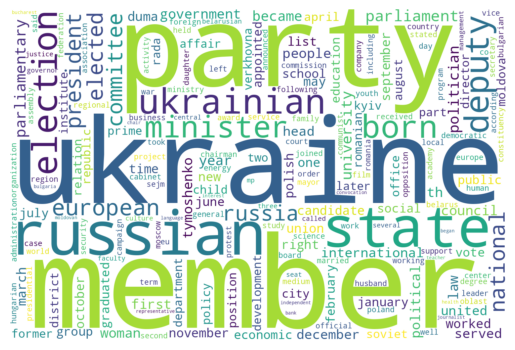

In [ ]:
# WordCloud based on all the tokens
# combine all tokens into one string
text = ""
for token_list in all_tokens:
    for token in token_list:
        text = text + " " + token

# Create and generate a word cloud image:
# https://www.datacamp.com/tutorial/wordcloud-python - parameters
wordcloud = WordCloud(background_color = "white", collocations = False,
                      width = 1500, height = 1000, stopwords = None).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Bigrams

In [ ]:
article_bigram = [list(nltkbigrams(article)) for article in all_tokens]

# Flatten list of bigrams
bigrams_list = list(itertools.chain(*article_bigram))

# Create counter of words in bigrams list
bigram_counts = Counter(bigrams_list)
print('Number of unique bigrams in the articles:', len(bigram_counts))

bigram_df = pd.DataFrame(bigram_counts.most_common(100), columns=['bigram', 'count'])

bigram_df.head(50)

Number of unique bigrams in the articles: 113251


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,bigram,count
0,"(state, duma)",330
1,"(prime, minister)",302
2,"(parliamentary, election)",293
3,"(verkhovna, rada)",260
4,"(european, parliament)",209
5,"(human, right)",163
6,"(united, state)",140
7,"(russian, federation)",140
8,"(people, deputy)",139
9,"(united, russia)",138


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


from matplotlib import pyplot as plt
_df_2['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['count'].plot(kind='hist', bins=20, title='count')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='index', y='count', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['count']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_7['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_8['count'].plot(kind='line', figsize=(8, 4), title='count')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
# Writing top 100 bigrams for all articles by frequency to a CSV file
bigram_df.to_csv('output/EE_bigrams_100.csv', index = False, header = True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


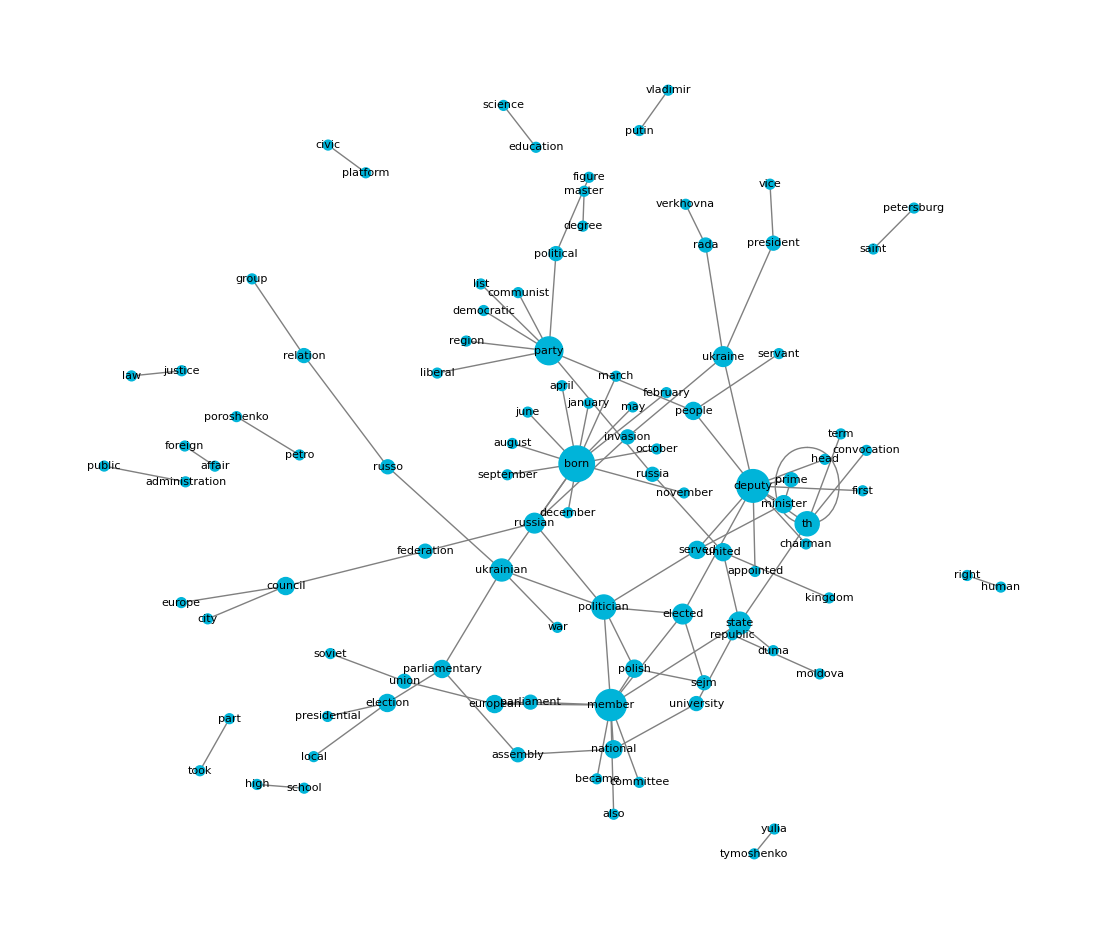

In [ ]:
# Bigram visualisation
# https://github.com/oliviatan29/network_analysis/blob/main/Network%20Analysis%20-%20Indonesian%20Food%20Ingredients.ipynb
# Create dictionary of edges and their weights
d = bigram_df.set_index('bigram').T.to_dict('records')

# Create network plot
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

# Use node degree as the node size

fig, ax = plt.subplots(figsize=(14, 12))

pos = nx.spring_layout(G, k=2)

d = dict(G.degree)

nx.draw(G, pos,
        font_size = 8,
        width = 1,
        edge_color = 'grey',
        node_color = '#00b4d9',
        with_labels = True,
        nodelist = list(d.keys()),
        node_size = [v * 50 for v in d.values()])
plt.show()

In [ ]:
# https://github.com/oliviatan29/network_analysis/tree/main
# Define get_nodes_and_nbrs()
def get_nodes_and_nbrs(G, nodes_of_interest):
    """
    Returns a subgraph of the graph `G` with only the `nodes_of_interest` and their neighbors.
    """
    nodes_to_draw = []
    # Iterate over the nodes of interest
    for n in nodes_of_interest:
        # Append the nodes of interest to nodes_to_draw
        nodes_to_draw.append(n)
        # Iterate over all the neighbors of node n
        for nbr in G.neighbors(n):
            # Append the neighbors of n to nodes_to_draw
            nodes_to_draw.append(nbr)
    return G.subgraph(nodes_to_draw)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


i can look at big model, and pick the word to do deep dive in this mini graph below

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


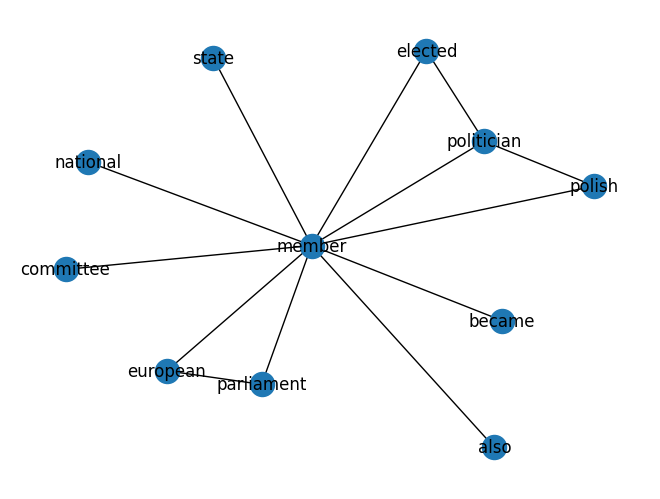

In [ ]:
# Extract the subgraph with the nodes of interest: T_draw
T_draw = get_nodes_and_nbrs(G, ['member'])

# Draw the subgraph to the screen
nx.draw(T_draw, with_labels=True)
plt.show()

In [ ]:
# Or as a list
list(G.adj['politician'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['polish', 'russian', 'member', 'served', 'ukrainian', 'elected']

## Trigrams

In [ ]:
# Train a toy phrase model on our training corpus.
phrase_model = Phrases(all_tokens, min_count = 10, threshold = 50, connector_words = ENGLISH_CONNECTOR_WORDS)

# Train trigram model on all tockets
trigram  = Phrases(phrase_model[all_tokens], min_count = 10)
#print(trigram)

# Create a list of all trigrams
trigram_list = []
for token in all_tokens:
    trigrams_ = [t for t in trigram[phrase_model[token]] if t.count('_')==2]
    if len(trigrams_) > 0:
        trigram_list.append(trigrams_)

print('Total number of documents with trigrams:', len(trigram_list))

# create dictionary of trigrams
trigram_dic = Dictionary(trigram_list)
print('Number of unique trigrams:', len(trigram_dic.keys()))

# Top 100 tigrams by frequency in all articles
trigram_most_freq = trigram_dic.most_common(100)
print('\nTop 20 trigrams by frequency\n')

num = 1
for t, f in trigram_most_freq[:20]:
    print(str(num) + '.', t, '-', f)
    num = num + 1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total number of documents with trigrams: 361
Number of unique trigrams: 58

Top 20 trigrams by frequency

1. verkhovna_rada_ukraine - 59
2. th_state_duma - 55
3. united_russia_party - 53
4. russian_invasion_ukraine - 45
5. relation_russo_ukrainian - 42
6. deputy_prime_minister - 40
7. sanctioned_uk_government - 39
8. russian_political_figure - 36
9. deputy_state_duma - 34
10. september_getting_vote - 31
11. ukrainian_presidential_election - 31
12. elected_verkhovna_rada - 30
13. tara_shevchenko_national - 27
14. national_assembly_mp - 25
15. president_vladimir_putin - 24
16. inter_parliamentary_relation - 24
17. committee_foreign_affair - 23
18. petro_poroshenko_bloc - 23
19. foreign_affair_minister - 21
20. servant_people_party - 20


In [ ]:
# Writing top 20 trigrams for all articles by frequency to a CSV file
top_trigram_df = pd.DataFrame(trigram_most_freq[:20])
top_trigram_df.columns = ['trigram', 'frequency']
top_trigram_df.to_csv('output/EE_trigrams_20.csv', index = False, header = True)

## Optimal number of topics

https://radimrehurek.com/gensim/models/coherencemodel.html

Best coherence for umass is typically the minimum. Best coherence for c_v is typically the maximum. Umass is faster than c_v, but in my experience c_v gives better scores for optimal number of topics. This is not a hard decision rule. It depends on the use case. If you're evaluating topics for human readability you would probably want to compare a few models with low umass to see how the top keywords look with something like pyLDAvis. Vice versa for c_v. (https://groups.google.com/g/gensim/c/Ybja9B15F1E?pli=1)

In [1]:
topics = []
score = []
for i in range(1,21,1):
    lda_model = LdaMulticore(corpus = corpus, id2word = dictionary,
                             iterations = 10, num_topics = i,
                             workers = 4, passes = 10,
                             random_state = 100)
    cm = CoherenceModel(model = lda_model, corpus = corpus, dictionary = dictionary,
                        coherence='u_mass')
    topics.append(i)
    score.append(cm.get_coherence())

_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

NameError: name 'LdaMulticore' is not defined

In [ ]:
# Calculating the coherence score using C_v
# also cm.get_coherence_per_topic()
topics = []
score = []
for i in range(1,20,1):
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary,
                             iterations=10, num_topics=i,
                             workers = 4, passes=10, random_state=100)
    cm = CoherenceModel(model=lda_model, texts = all_tokens, corpus=corpus,
                        dictionary=dictionary,
                        coherence='c_v')
    topics.append(i)
    score.append(cm.get_coherence())

_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

## LDA model

In [ ]:
# Train our lda model
lda_model = LdaMulticore(corpus = corpus, id2word = dictionary,
                         iterations = 10, num_topics = 5,
                         workers = 4, passes = 10,
                         random_state = 100)

cm = CoherenceModel(model = lda_model, corpus = corpus, dictionary = dictionary,
                        coherence='u_mass')
cm_score = cm.get_coherence()

print('LDA model coherence score:', cm_score)

# For each topic, we will explore the words occuring in that topic and its relative weight.
for idx, topic in lda_model.print_topics(-1):
    print('\nTopic: {} \nWords: {}'.format(idx, topic))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LDA model coherence score: -0.9258717499975256

Topic: 0 
Words: 0.026*"party" + 0.026*"european" + 0.023*"member" + 0.019*"parliament" + 0.018*"minister" + 0.018*"election" + 0.015*"national" + 0.014*"committee" + 0.014*"president" + 0.013*"parliamentary"

Topic: 1 
Words: 0.031*"deputy" + 0.029*"state" + 0.022*"member" + 0.019*"ukrainian" + 0.018*"russian" + 0.018*"duma" + 0.018*"party" + 0.016*"th" + 0.016*"ukraine" + 0.014*"committee"

Topic: 2 
Words: 0.030*"russian" + 0.017*"ukraine" + 0.015*"russia" + 0.013*"election" + 0.012*"ukrainian" + 0.011*"party" + 0.011*"state" + 0.009*"president" + 0.009*"also" + 0.008*"year"

Topic: 3 
Words: 0.030*"ukraine" + 0.021*"ukrainian" + 0.014*"woman" + 0.012*"international" + 0.012*"member" + 0.009*"moldova" + 0.009*"right" + 0.009*"minister" + 0.009*"national" + 0.008*"also"

Topic: 4 
Words: 0.022*"russian" + 0.020*"polish" + 0.017*"state" + 0.016*"sejm" + 0.015*"member" + 0.014*"russia" + 0.010*"deputy" + 0.010*"elected" + 0.010*"september

## LDA Visualisation

In [ ]:
#Creating Topic Distance Visualization
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.051144  0.036946       1        1  24.476872
0      0.089055 -0.015591       2        1  23.331120
1     -0.030144 -0.063809       3        1  20.553610
3      0.018790  0.054734       4        1  19.711867
4     -0.026557 -0.012280       5        1  11.926530, topic_info=              Term         Freq        Total Category  logprob  loglift
195        russian  1339.000000  1339.000000  Default  30.0000  30.0000
492         polish   353.000000   353.000000  Default  29.0000  29.0000
72        european   789.000000   789.000000  Default  28.0000  28.0000
273         deputy   998.000000   998.000000  Default  27.0000  27.0000
593           duma   438.000000   438.000000  Default  26.0000  26.0000
..             ...          ...          ...      ...      ...      ...
325            one    63.560171   406.793011   Topic5  -5.1472   0.2701
230      ukrainian    72.101968  1120.919731   Topic5  -5.0211  -0.6174
328  parliamentary    66.703499   670.146893   Topic5  -5.0989  -0.1808
153          party    70.608767  1343.965347   Topic5  -5.0420  -0.8198
168      president    65.023864   734.565784   Topic5  -5.1244  -0.2981

[316 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         1  0.608286  according
0         2  0.085462  according
0         3  0.100543  according
0         4  0.135733  according
0         5  0.070380  according
...     ...       ...        ...
506       1  0.080581      young
506       2  0.268605      young
506       3  0.120872      young
506       4  0.483489      young
506       5  0.067151      young

[1094 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 4, 5])

## Bigram visualisation - Node colouring by topic

In [ ]:
# Creating dataframe with node names and topics identified by LDA for colour coding nodes
# ISSUE: many words do not have topics - bigrams in dictionary?
#->> These tokens are not in the dictionary (as bigrams are build based on full token list)
nodes_df = pd.DataFrame(list(G.nodes), columns=['nodes'])

# After LDA model is built
topic_list = []
for word in nodes_df.nodes:
    try:
        t_probability = lda_model.get_term_topics(word)
        # Find for the topic with the highest probability
        if len(t_probability) > 1:
            highest_topic = ''
            highest_probability = 0
            for topic, prob in t_probability:
                if prob > highest_probability:
                    highest_topic = topic
                    highest_probability = prob
            topic_list.append(highest_topic)
        else:
            topic_list.append(t_probability[0][0])
    except (RuntimeError, TypeError, NameError, IndexError):
        topic_list.append('')
        pass
nodes_df['topic'] = topic_list
# Convert topic column to catgorical
nodes_df['topic'] = pd.Categorical(nodes_df['topic'])

nodes_df.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,nodes,topic
0,state,1
1,duma,1
2,prime,
3,minister,0
4,parliamentary,0
5,election,0
6,verkhovna,
7,rada,
8,european,0
9,parliament,0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


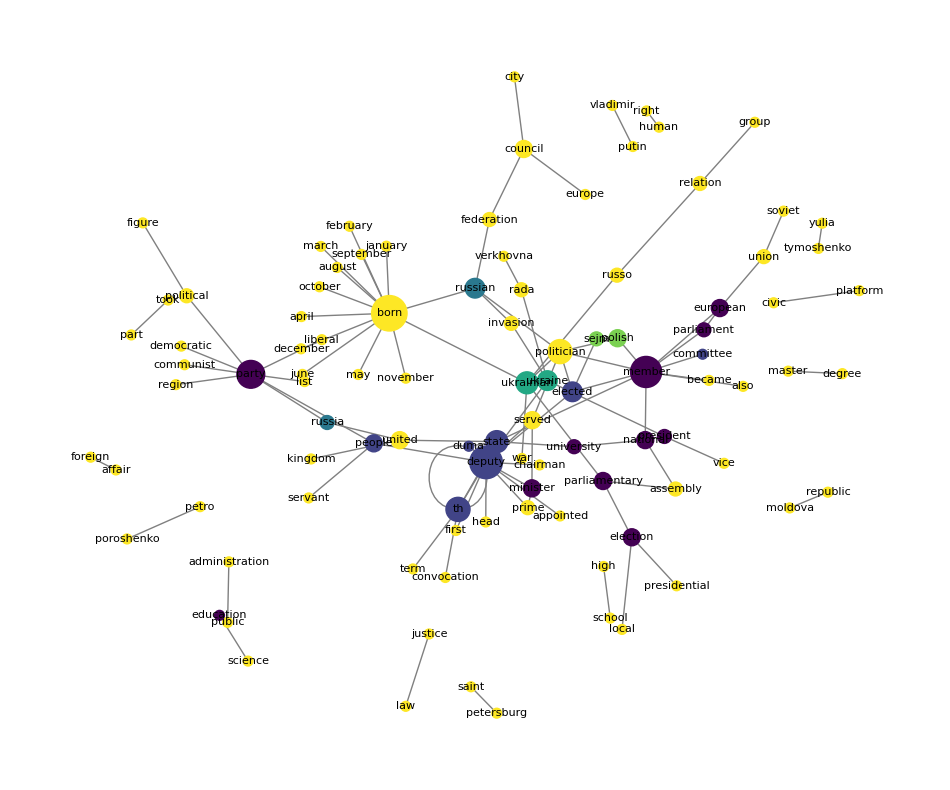

In [ ]:
# Bigram visualisation
# https://github.com/oliviatan29/network_analysis/blob/main/Network%20Analysis%20-%20Indonesian%20Food%20Ingredients.ipynb
# Create dictionary of edges and their weights
d = bigram_df.set_index('bigram').T.to_dict('records')

# Create network plot
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

# Use node degree as the node size

fig, ax = plt.subplots(figsize=(12, 10))

pos = nx.spring_layout(G, k=2)

d = dict(G.degree)

nx.draw(G, pos,
        font_size=8,
        width=1,
        edge_color='grey',
        node_color = nodes_df['topic'].cat.codes,
        with_labels = True,
        nodelist=list(d.keys()),
        node_size=[v * 50 for v in d.values()])
plt.show()

In [ ]:
# 0 - dark purple
# NA - yellow (common across all documents)

print('Number of nodes per topic:')
print(nodes_df['topic'].value_counts().sort_index())

Number of nodes per topic:
topic
0    11
1     7
2     2
3     2
4     2
     77
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Testing model

In [ ]:
# probability of a word belonging to a topic
test_words = ['european', 'woman', 'served', 'elected']
for word in test_words:
    try:
        t_probability = lda_model.get_term_topics(word)
        print('\nWord:', word, ' - belongs to:')
        for topic, prob in t_probability:
             print('Topic: {} \nProbability: {}\n'.format(topic, prob))
    except IndexError:
        pass


Word: european  - belongs to:
Topic: 0 
Probability: 0.06170090660452843

Topic: 8 
Probability: 0.012142736464738846


Word: woman  - belongs to:
Topic: 1 
Probability: 0.010541661642491817

Topic: 3 
Probability: 0.014930302277207375

Topic: 5 
Probability: 0.01693888194859028


Word: served  - belongs to:
Topic: 1 
Probability: 0.014407980255782604

Topic: 7 
Probability: 0.011427057906985283


Word: elected  - belongs to:
Topic: 1 
Probability: 0.016755618155002594

Topic: 2 
Probability: 0.026537824422121048

Topic: 6 
Probability: 0.012585447169840336

Topic: 7 
Probability: 0.01687142811715603



In [ ]:
query = 'Leadership is the ability of an individual or a group of people to influence and guide followers or members of an organization, society or team.'
vec_bow = dictionary.doc2bow(query.lower().split())

# convert the query to LSI space
vec_lda = lda_model[vec_bow]
# This shows how the query relates to the topics
vec_lda

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, 0.034021806),
 (1, 0.034192428),
 (2, 0.034052376),
 (3, 0.8637065),
 (4, 0.03402689)]